# Model discovery MoD1

In this notebook, we'll discover model of EWH1 (OSO300L) form the TB datat in MoD1, i.e., we have Temperature, draw debit(m³/s), and power consumption(W)

In [26]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt
import tkinter as tk
from tkinter import filedialog
import os

#Function file import
import DeepMod_Functions as DD_func
# DeepMoD functions


from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.constraint import LeastSquares, GradParams, Ridge
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat


import torch
from torch.autograd import grad
from itertools import combinations
from functools import reduce
from typing import Tuple
from deepymod.utils.types import TensorList
from deepymod import Library

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)

# Configuring GPU or CPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cpu


Before we send the data into the Dataset format, create a plot to get an idea of the data:


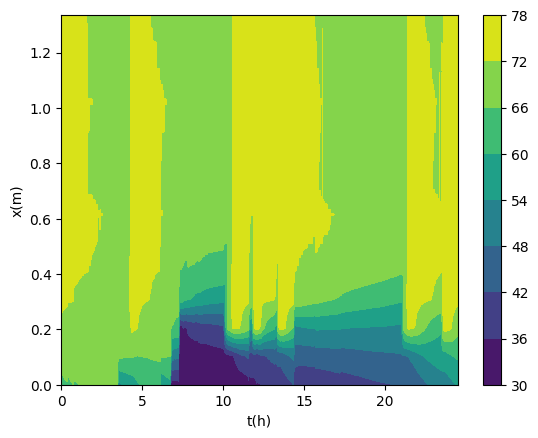

In [27]:
#Asking the filename to the user(It will be a .npy file for the moment we'll see after if we need to import other fomat as .mat or ohter, think of a preprocess script for the essay datas at Canmet)
application_window = tk.Tk() 
fTyp = [("fichier de données (*.npy)", "*.npy")]
file_name = filedialog.askopenfilename(parent=application_window,
                                    initialdir=os.getcwd(),
                                    title="Please select your npy file containing the datas and its coords:",
                                    filetypes=fTyp)


application_window.destroy()
#Display the data 
data = np.load(file_name, allow_pickle=True).item()
fig, ax = plt.subplots()
im = ax.contourf(data['t']/3600, data['x'], np.real(data['T']))
ax.set_xlabel('t(h)')
ax.set_ylabel('x(m)')
fig.colorbar(mappable=im)

plt.show()

We can now pass the function that loads the data to the DeePyMoD Dataset module, which loads the data, preprocesses it, subsamples it and then sends it to the right device.

In [28]:
dataset = Dataset(
    load_function= DD_func.load_MoD1,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 500000, 
    },
    load_kwargs= {"file": file_name},
     preprocess_kwargs={
        "normalize_coords": False,
        "normalize_data":  False
    }, 
    device=device,
    apply_normalize= DD_func.custom_normalize,
)
 
#Now we need to split our data into a train and test dataloaders for PyTorch
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.9)


Dataset is using device:  cpu


## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [29]:
network = NN(5, [100, 100, 100, 100], 1)

Configuration of the library function: We select the custom build library we created earlier
* [$1, (T - T_{a}), \frac{\partial T}{\partial x}, \frac{\partial^{2} T}{\partial x^{2}}, V \frac{\partial T}{\partial x}$] 

In [30]:
Library = DD_func.Library_MoD1()

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-8, the algorithm is converged.

In [31]:
#Sparsity scheduler
estimator = Threshold(1e-5)
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)

#Configuration of the sparsity estimator
constraint = LeastSquares()

# Now, we instantiate the model and select the optimizer
model = DeepMoD(network, Library, estimator, constraint).to(device)

#Defining optimizer
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3
)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [32]:
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir= os.getcwd() + "\\Logdir\\MoD1\\" ,
    max_iterations=10000,
    delta=1e-5,
    patience=200
)

  3150  MSE: 1.01e+02  Reg: 1.50e-19  L1: 1.36e+00 Algorithm converged. Writing model to disk.


Now that DeepMoD has converged, it has found the following coefficients to not be zero: 

In [33]:
model.sparsity_masks

[tensor([True, True, True, True, True, True])]

And it found the following coefficients.

In [34]:
model.estimator_coeffs()

[array([[ 0.        ],
        [ 0.        ],
        [ 0.5208883 ],
        [-0.44284773],
        [ 0.31321692],
        [ 0.        ]], dtype=float32)]

Then the absolute value of the coefficients
* [$1, (T - T_{a}), \frac{\partial T}{\partial x}, \frac{\partial^{2} T}{\partial x^{2}}, V \frac{\partial T}{\partial x}$]  


In [35]:
print(model.library.norms[0].cpu().numpy() * model.estimator_coeffs()[0][:,0])
coeff_norm = model.library.norms[0].cpu().numpy() * model.estimator_coeffs()[0][:,0]

[ 0.0000000e+00  0.0000000e+00  2.0980783e+00 -5.8194232e+00
  2.8217288e+05  0.0000000e+00]


We have now to denormalize it a second time because, we just have the relation for the normalized(data and coords) terms of the equation

In [36]:
#TODO